In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# -------------------------------
# 1. Load CIFAR-10 and preprocess
# -------------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Use only grayscale intensity if needed
x_train_gray = np.mean(x_train, axis=-1)
x_test_gray = np.mean(x_test, axis=-1)

# Flatten images: (N, 32, 32) -> (N, 1024)
x_train_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_flat = x_test_gray.reshape(x_test_gray.shape[0], -1)

# Normalize the pixel values
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

# -------------------------------
# 2. Use 70% of training for PCA
# -------------------------------
x_train_pca, _, y_train_pca, _ = train_test_split(
    x_train_flat, y_train, train_size=0.7, stratify=y_train, random_state=42
)

# -------------------------------
# 3. Apply PCA with 95% energy
# -------------------------------
pca = PCA(n_components=0. , svd_solver='full')
x_train_pca_reduced = pca.fit_transform(x_train_pca)
x_test_pca_reduced = pca.transform(x_test_flat)

print(f"Original dimension: {x_train_pca.shape[1]}")
print(f"Reduced dimension (95% variance): {x_train_pca_reduced.shape[1]}")

# -------------------------------
# 4. Train logistic regression
# -------------------------------
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
clf.fit(x_train_pca_reduced, y_train_pca.ravel())

# Predict and evaluate
y_pred = clf.predict(x_test_pca_reduced)
top_eigenvectors = pca.components_


print(f"Top Eigen vaectors : {top_eigenvectors}")

Original dimension: 1024
Reduced dimension (95% variance): 161


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Top Eigen vaectors : [[ 0.03969205  0.04004706  0.04015573 ...  0.03235171  0.03246445
   0.03254571]
 [-0.03122029 -0.03209432 -0.03276056 ...  0.03327389  0.03185466
   0.03002012]
 [-0.02557158 -0.02558845 -0.02537941 ... -0.03786341 -0.03794331
  -0.03740892]
 ...
 [-0.01815051 -0.03267054 -0.03547379 ...  0.00475201  0.01107296
   0.01469299]
 [-0.04022875 -0.03703409 -0.00888558 ... -0.00696873  0.01319619
   0.02654599]
 [ 0.03309647  0.03093516  0.02358159 ... -0.01199677  0.00820211
   0.03179666]]


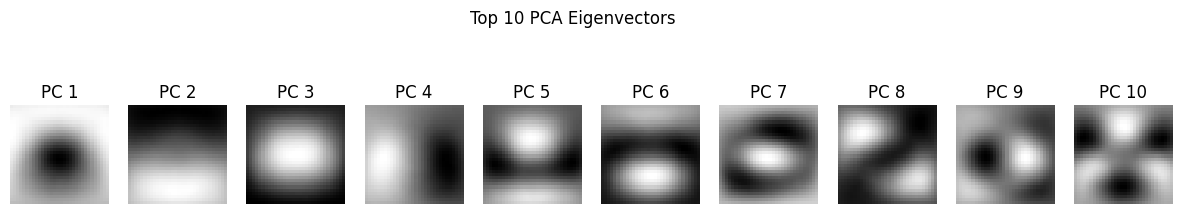

highest eigen value 299


In [ ]:
import matplotlib.pyplot as plt

def visualize_pca_components(pca, num_components=10):
    fig, axes = plt.subplots(1, num_components, figsize=(15, 3))
    for i in range(num_components):
        ax = axes[i]
        component = pca.components_[i].reshape(32, 32)
        ax.imshow(component, cmap='gray')
        ax.set_title(f"PC {i+1}")
        ax.axis('off')
    plt.suptitle(f"Top {num_components} PCA Eigenvectors")
    plt.show()

# Visualize
visualize_pca_components(pca, num_components=10)
# Make sure `pca` is your trained PCA object from sklearn
eigenvalues = pca.explained_variance_
num_hidden_nodes = int(np.round(eigenvalues[0]))
print(f"highest eigen value",num_hidden_nodes)


# ***1. Import the required libraries***
1. conda install tensorflow-datasets
2. conda install scikit-learn
3. conda install seaborn


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist


# ***2. Data Acquisition***
https://www.tensorflow.org/datasets/catalog/cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## ***2.1 Display the Original Image***

In [ ]:
def show_images(images, labels=None, num=5, cmap=None, figsize=(15, 3)):
	plt.figure(figsize=figsize)
	for i in range(num):
					plt.subplot(1, num, i+1)
					if images.ndim == 4:  # e.g. (N, H, W, 3) or (N, H, W, 1)
									img = images[i]
									# if single channel, squeeze to 2D for imshow
									if img.shape[-1] == 1:
													img = img.squeeze(-1)
									plt.imshow(img, cmap=cmap)
					elif images.ndim == 3:  # e.g. (N, H, W)
									plt.imshow(images[i], cmap=cmap)
					else:
									raise ValueError("Unsupported image array shape")

					if labels is not None:
									plt.title(f"Label: {labels[i]}")
					plt.axis('off')
	plt.show()

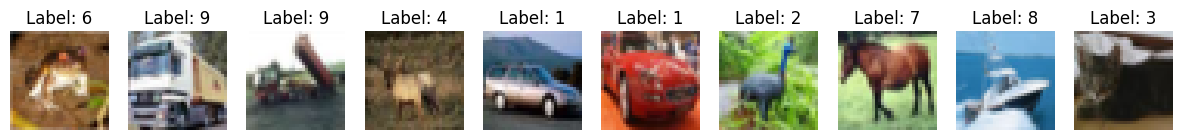

In [ ]:
show_images(x_train, labels=y_train.flatten(), num=10, cmap='gray')

# ***3. Data Preparation /Normalizatoin based on Images***

In [ ]:
# Convert to float in [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Now convert to grayscale
x_train_gray = np.array([rgb2gray(img) for img in x_train])  # shape: (50000, 32, 32)
x_test_gray = np.array([rgb2gray(img) for img in x_test])    # shape: (10000, 32, 32)

# Add channel dimension for Conv2D
x_train_gray = x_train_gray[..., np.newaxis]  # shape: (50000, 32, 32, 1)
x_test_gray = x_test_gray[..., np.newaxis]

In [ ]:
print(np.min(x_train_gray), np.max(x_train_gray))


0.0 0.99999994


# ***4. Deep Convolutional AutoEncoder***

In [ ]:

input_img = layers.Input(shape=(32, 32, 1))

# Encoder
x = layers.Conv2D(32, (3, 3),  padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 8x8
x = layers.Conv2D(128, (3, 3),  padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4 latent space
x=layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4 latent space
encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)  #
# Decoder

x = layers.Conv2D(128, (3, 3),  padding='same')(encoded)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D((2, 2))(x)  # 8x8
x = layers.Conv2D(64, (3, 3),  padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D((2, 2))(x)  # 32x32

# Output layer with 1 channel for grayscale
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Build model
conv_autoencoder  = models.Model(input_img, decoded)
conv_autoencoder .compile(optimizer='adam', loss='mse')


In [ ]:
print(conv_autoencoder.output_shape)

(None, 32, 32, 1)


# ***5. Single Hidden Layer Autoencoder***

In [ ]:
input_img = layers.Input(shape=(32, 32, 1))
flat = layers.Flatten()(input_img)  # shape: (None, 1024)
latent_dim = num_hidden_nodes
# Encoder: single hidden layer with sigmoid activation
encoded = layers.Dense(latent_dim, activation='sigmoid')(flat)

# Decoder: linear activation (no activation)
decoded = layers.Dense(32*32, activation='linear')(encoded)

# Reshape back to image shape
decoded_img = layers.Reshape((32, 32, 1))(decoded)

fc_autoencoder = models.Model(input_img, decoded_img)
fc_autoencoder.compile(optimizer='adam', loss='mse')


# ***6. Three Hidden Layer Autoencoder***

In [ ]:



layer1 = layer2 = layer3 = 299 // 3
input_img = layers.Input(shape=(32, 32, 1))
flat = layers.Flatten()(input_img)

# Encoder: 3 hidden layers with sigmoid activation
x = layers.Dense(layer1, activation='sigmoid')(flat)
x = layers.Dense(layer2, activation='sigmoid')(x)
encoded = layers.Dense(layer3, activation='sigmoid')(x)

# Decoder: mirror the encoder
x = layers.Dense(layer1, activation='sigmoid')(encoded)
x = layers.Dense(layer2, activation='sigmoid')(x)
decoded = layers.Dense(32*32, activation='linear')(x)

decoded_img = layers.Reshape((32, 32, 1))(decoded)

fc3_autoencoder = models.Model(input_img, decoded_img)
fc3_autoencoder.compile(optimizer='adam', loss='mse')


# ***7.Model Report***
*   Deep Convolution AutoEncoder
*   Single Hidden layer AutoEncoder
*   Three Hidden layer AutoEncoder

In [ ]:
conv_autoencoder.summary()
fc_autoencoder.summary()
fc3_autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 777,217 (2.96 MB)

 Trainable params: 776,321 (2.96 MB)

 Non-trainable params: 896 (3.50 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 299)            │       306,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │       307,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,675 (2.34 MB)

 Trainable params: 613,675 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 99)             │       101,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 99)             │         9,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 99)             │         9,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 99)             │         5,049 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,724 (912.98 KB)

 Trainable params: 233,724 (912.98 KB)

 Non-trainable params: 0 (0.00 B)

# ***8. Model Training***

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train convolutional autoencoder
conv_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray),callbacks=[early_stop])

# Train fully connected autoencoder
fc_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

# Train fully 3 hidden layer connected autoencoder
fc3_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 18085.7715 - val_loss: 18240.6875
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 18070.8711 - val_loss: 18240.5703
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 18055.0312 - val_loss: 18240.5605
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 17989.4570 - val_loss: 18240.5547
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 18051.7578 - val_loss: 18240.5527
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 18040.4648 - val_loss: 18240.5527
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 18067.5977 - val_loss: 18240.5508
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 18044.5430 - val_loss: 18240.5508
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 18026.3613 - val_loss: 18240.5508
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 18017.6797 - val_loss: 18240.5508
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 

# ***9. Reconstrunction Error Evaluation***

In [ ]:
import numpy as np

# Predict reconstructions
conv_decoded = conv_autoencoder.predict(x_test_gray)
fc_decoded = fc_autoencoder.predict(x_test_gray)
fc3_decoded = fc3_autoencoder.predict(x_test_gray)

# Compute mean squared error per sample and average
def mse_per_sample(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=(1,2,3))

conv_errors = mse_per_sample(x_test_gray, conv_decoded)
fc_errors = mse_per_sample(x_test_gray, fc_decoded)
fc3_errors = mse_per_sample(x_test_gray, fc3_decoded)

print("Conv Autoencoder Mean Reconstruction Error:", np.mean(conv_errors))
print("FC Autoencoder Mean Reconstruction Error:", np.mean(fc_errors))
print("FC3 Autoencoder Mean Reconstruction Error:", np.mean(fc3_errors))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


ValueError: operands could not be broadcast together with shapes (10000,32,32) (10000,32,32,1) 

In [ ]:
import matplotlib.pyplot as plt

def show_reconstruction(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_reconstruction(x_test_gray, conv_decoded, n=10)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick N random test images
n = 10
indices = np.random.choice(len(x_test_gray), n)
test_imgs = x_test_gray[indices]

# Get reconstructions
recon_cae = conv_autoencoder.predict(test_imgs)
recon_fcae = fc_autoencoder.predict(test_imgs)

# Plotting
plt.figure(figsize=(12, 5))

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_imgs[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Conv Autoencoder
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(recon_cae[i].squeeze(), cmap='gray')
    plt.title("Conv AE")
    plt.axis("off")

    # FC Autoencoder
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(recon_fcae[i].squeeze(), cmap='gray')
    plt.title("FC AE")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_reconstructions(orig, reconstructions, model_names, n=5):
    plt.figure(figsize=(15, 8))
    total_rows = len(reconstructions) + 1  # +1 for original
    total_cols = n

    for i in range(n):
        # Original image row (row 0)
        ax = plt.subplot(total_rows, total_cols, i + 1)
        plt.imshow(orig[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images rows (rows 1,2,...)
        for j, recon in enumerate(reconstructions):
            ax = plt.subplot(total_rows, total_cols, (j + 1) * total_cols + i + 1)
            plt.imshow(recon[i].squeeze(), cmap='gray')
            plt.title(model_names[j])
            plt.axis('off')
    plt.tight_layout()
    plt.show()
# Call with your models' reconstructions and names
plot_reconstructions(
    x_test_gray,
    [conv_decoded, fc_decoded, fc3_decoded],
    ["Conv AE", "FC 1-hidden AE", "FC 3-hidden AE"],
    n=5
)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Encode test images
latent_vectors = encoder.predict(x_test_gray)

# Reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='tab10', s=3)
plt.colorbar()
plt.title("Latent Space Visualization using t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()